# Loading data

In [1]:
import h5py
import numpy as np
import tonic

h5 = h5py.File('/home/aric/neuromorphic_workshop/workshop.h5', 'r')

events = h5['events_data'][:]
print(events.shape)

def arr_to_tonic(arr): #we will cover tonic later. For now just know that it is a format for storing events that is more memory efficient.
    out = np.zeros(len(arr), dtype=[('x', '<i2'), ('y', '<i2'), ('p', '?'), ('t', '<f8')])
    arr[:, 3] = arr[:, 3] * 1e6
    arr[:, 3] = arr[:, 3] - arr[0, 3]
    
    out['x'] = arr[:, 0].astype(np.int16)
    out['y'] = arr[:, 1].astype(np.int16)
    out['p'] = arr[:, 2].astype(bool)
    out['t'] = arr[:, 3].astype(np.float64)
    return out

events = arr_to_tonic(events)

(925123, 4)


In [2]:
#first and last 5 events
print("First 5 events:")
print(events[:5])
print("Last 5 events:")
print(events[-5:])

First 5 events:
[( 18, 163, False,    0.) (135, 255,  True,  143.)
 (134, 250,  True,  175.) (160, 224,  True, 1522.)
 ( 13,  29, False, 2995.)]
Last 5 events:
[(  9,  84,  True, 11493890.  ) (  3, 256, False, 11495324.75)
 (274,  71, False, 11495950.  ) ( 37,  23,  True, 11497230.  )
 (100, 159, False, 11498301.  )]


## Event processing preliminary
Event-based data can be thought of as an irregularly sampled time series. Depending on the problem at hands, there are several ways of processing event camera data. We begin by first visualizing what event-based data is.

A natural way of doing so is to look at the 3D plots of the events. We can look at 30ms windows.

Time span:  11.498301 seconds
Number of 30 ms windows:  383


Text(0, 0.5, 'Number of events')

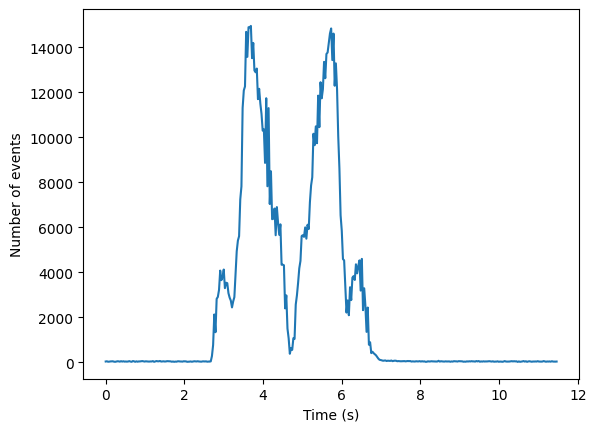

In [3]:
import matplotlib.pyplot as plt
ts0 = events[0]['t']
ts1 = events[-1]['t']

print("Time span: ", (ts1 - ts0) / 1e6, "seconds")

#30 ms windows
breaks = np.arange(ts0, ts1, 30e3)
print("Number of 30 ms windows: ", len(breaks) - 1)

#count events in each window
#we can exploit the fact that the events are sorted by time by using numpy's searchsorted function to search for the indices of the breaks in the events array
breaks_idx = np.searchsorted(events['t'], breaks)
counts = np.diff(breaks_idx)

plt.plot(breaks[:-1] / 1e6, counts, label='Events per 30 ms')
plt.xlabel('Time (s)')
plt.ylabel('Number of events')

In the above plot we see two almost mirrored peaks corresponding to the two motion directions. We also see that during non motion, there is almost zero eventd. We will come back to this point later.

Most events in a 30 ms window:  14944 at time 3.690001 seconds


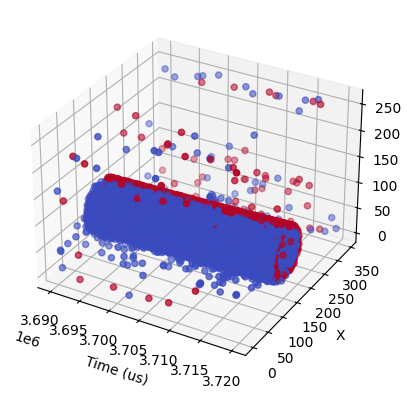

In [4]:
max_events_idx = np.argmax(counts)
max_events = counts[max_events_idx]

# plot in 3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

most_events = events[breaks_idx[max_events_idx]:breaks_idx[max_events_idx + 1]]

ax.scatter(most_events['t'], most_events['x'], most_events['y'], c=most_events['p'], cmap='coolwarm')
ax.set_xlabel('Time (us)')
ax.set_ylabel('X')
ax.set_zlabel('Y')

print("Most events in a 30 ms window: ", max_events, "at time", most_events[0]['t'] / 1e6, "seconds")


As seen event-based data is very different than what you are probably used from a regular camera. One way of dealing with event data is to convert the incoming 

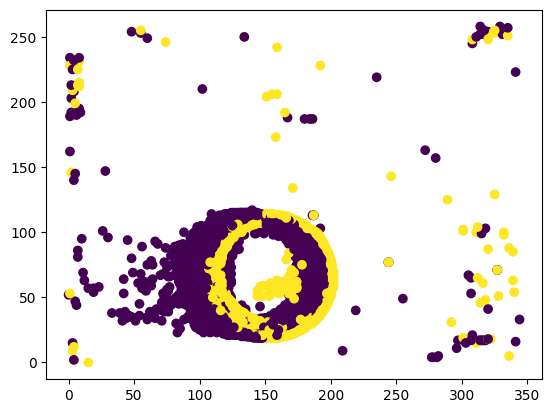

In [5]:
plt.scatter(most_events['x'], most_events['y'], c=most_events['p'])